In [1]:
import os
import sys

#from obspy import UTCDateTime #, read, read_events
#from obspy.core.event import Comment #Event, Origin, Arrival, Pick, WaveformStreamID, Catalog

SOURCE_DIR = '/data/Pinatubo/PHASE'
REPO_DIR = '/home/thompsong/Developer/Pinatubo1991SeismicData'
seisan_db_name = 'PNTBO'
SEISAN_TOP = '/data/SEISAN_DB'
REA_DIR = os.path.join(SEISAN_TOP, 'REA', seisan_db_name)
WAV_DIR = os.path.join(SEISAN_TOP, 'WAV', seisan_db_name)
DEV_DIR = '/home/thompsong/Developer'
LIB_DIR = os.path.join(DEV_DIR, 'SoufriereHillsVolcano', 'lib')
sys.path.append(LIB_DIR)

In [3]:
# create (or load) a wfdisc table and corresponding catalog
import glob
from libseisGT import index_waveformfiles
import pandas as pd
from obspy import read_events, UTCDateTime
wfdisc_csv = os.path.join(REPO_DIR, 'metadata', 'wfdisc_catalog.csv')
wfdiscqml = os.path.join(REPO_DIR, 'metadata', 'wfdisc_catalog.xml')
if os.path.isfile(wfdisc_csv) and os.path.isfile(wfdiscqml):
    wfdiscdf = pd.read_csv(wfdisc_csv)
    for col in ['starttime', 'endtime']:
        wfdiscdf[col] = wfdiscdf[col].apply(lambda x: UTCDateTime(x) if pd.notna(x) else None)
    wfdisc_catalog = read_events(wfdiscqml)
else:
    # create a list of all wavfiles in the Seisan WAV database
    # Define the file pattern for Seisan WAV files

    print(f'got {len(wav_files)} wav files')    
    file_pattern = os.path.join(WAV_DIR, "*", "*", f"*M.{seisan_db_name}_*")
    wav_files = sorted(glob.glob(file_pattern))   
    wfdiscdf, wfdisc_catalog = index_waveformfiles(wav_files, ampeng=True, events=True)
    wfdiscdf.to_csv(wfdisc_csv, index=None)
    wfdisc_catalog.write(wfdiscqml, format="QUAKEML")
    print(f"\n✅ Saved wfdisc catalog as {wfdiscqml}")

print(f'The wfdisc catalog has {wfdisc_catalog.count()} events')

The wfdisc catalog has 21454 events


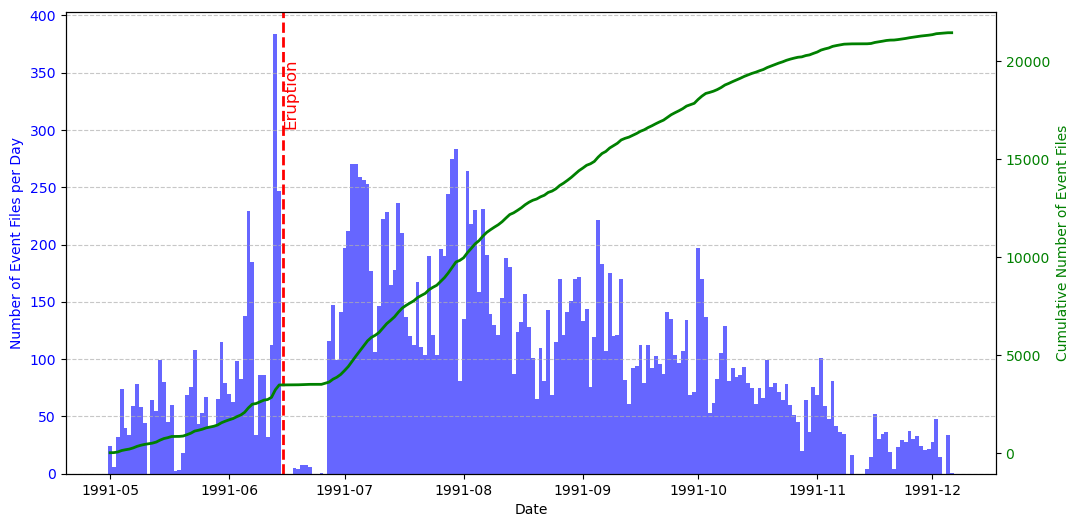

grouping took 0.539413 seconds


In [5]:
#import pandas as pd
import matplotlib.pyplot as plt
from obspy import UTCDateTime

t0 = UTCDateTime()

# Ensure df has a 'starttime' column in UTCDateTime format
df_grouped = wfdiscdf.groupby('file_index').first().reset_index()  # Keep unique start times

# Extract date from starttime
#df_grouped['starttime'] = df_grouped['starttime'].apply(lambda x: UTCDateTime(x))  # Convert to date (YYYY-MM-DD)
df_grouped['date'] = df_grouped['starttime'].apply(lambda x: x.date)  # Convert to date (YYYY-MM-DD)

# Count unique events per day
daily_counts = df_grouped['date'].value_counts().sort_index()

# Compute cumulative sum of events
cumulative_counts = daily_counts.cumsum()

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for daily event counts
ax1.bar(daily_counts.index, daily_counts.values, color='blue', alpha=0.6, width=1.0, label='Events per Day')
ax1.set_xlabel("Date")
ax1.set_ylabel("Number of Event Files per Day", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
#ax1.set_title("Number of Unique Events per Day and Cumulative Count")

# Create second y-axis for cumulative events
ax2 = ax1.twinx()
ax2.plot(cumulative_counts.index, cumulative_counts.values, color='green', linestyle='-', linewidth=2, label='Cumulative Events')
ax2.set_ylabel("Cumulative Number of Event Files", color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add vertical dashed red line for eruption
eruption_time = UTCDateTime("1991-06-15T13:42:00").date
ax1.axvline(x=eruption_time, color='red', linestyle='--', linewidth=2, label='Eruption')

# Add annotation for eruption
ax1.text(eruption_time, ax1.get_ylim()[1] * 0.9, "Eruption", color='red', fontsize=12, rotation=90, verticalalignment='top')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Grid and legend
ax1.grid(axis='y', linestyle='--', alpha=0.7)
#fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

# Show plot
plt.show()

t1 = UTCDateTime()
print(f'grouping took {t1-t0} seconds')


Try to very roughly estimate network magnitude from amplitudes, and from energy

,file_index,event_id,waveform_id,traceID,starttime,endtime,npts,sampling_rate,calib,ddir,dfile,duration,amplitude,energy,date,sta_mag_e,sta_mag_a
0,0,smi:local/fb81299e-57f4-4282-9eaf-492b8f7d71d8,"1991-05-01-0310-09M.PNTBO_005,[0]",XB.IRIG..ACE,1991-05-01 03:10:09.950,1991-05-01T03:10:50.572400Z,4096,100.806452,1.0,/data/SEISAN_DB/WAV/PNTBO/1991/05,1991-05-01-0310-09M.PNTBO_005,40.62240,32.471562,7.872405e+05,1991-05-01,1.948054,1.511503
1,1,smi:local/b9d80e1c-28c3-489f-8b51-9bc34b39612d,"1991-05-01-0339-42M.PNTBO_005,[3]",XB.PIE..EHZ,1991-05-01 03:39:42.521,1991-05-01T03:40:58.696680Z,7680,100.806452,1.0,/data/SEISAN_DB/WAV/PNTBO/1991/05,1991-05-01-0339-42M.PNTBO_005,76.17568,1409.245854,1.421851e+08,1991-05-01,3.076427,3.148987
2,2,smi:local/eb49effa-9cd4-4597-9c8e-7cade874bf9f,"1991-05-01-1045-26M.PNTBO_004,[0]",XB.IRIG..ACE,1991-05-01 10:45:26.647,1991-05-01T10:46:12.348440Z,4608,100.806452,1.0,/data/SEISAN_DB/WAV/PNTBO/1991/05,1991-05-01-1045-26M.PNTBO_004,45.70144,30.578870,8.231812e+05,1991-05-01,1.957748,1.485421
3,3,smi:local/8c42bf9a-d10f-473d-850d-9af79211b752,"1991-05-01-1049-40M.PNTBO_004,[0]",XB.IRIG..ACE,1991-05-01 10:49:40.597,1991-05-01T10:50:26.298440Z,4608,100.806452,1.0,/data/SEISAN_DB/WAV/PNTBO/1991/05,1991-05-01-1049-40M.PNTBO_004,45.70144,31.611906,8.272466e+05,1991-05-01,1.958817,1.499851
4,4,smi:local/be4f9957-7701-43f2-b814-c7c0be5d5561,"1991-05-01-1120-14M.PNTBO_004,[3]",XB.CAB..EHZ,1991-05-01 11:20:14.116,1991-05-01T11:20:59.817440Z,4608,100.806452,1.0,/data/SEISAN_DB/WAV/PNTBO/1991/05,1991-05-01-1120-14M.PNTBO_004,45.70144,85.960529,2.617259e+06,1991-05-01,2.208923,1.934299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21446,21449,smi:local/9d3bf56d-08a0-4e23-bffb-2977b3f50d36,"1991-12-05-2112-24M.PNTBO_007,[5]",XB.CAB..EHN,1991-12-05 21:12:24.596,1991-12-05T21:13:40.771680Z,7680,100.806452,1.0,/data/SEISAN_DB/WAV/PNTBO/1991/12,1991-12-05-2112-24M.PNTBO_007,76.17568,25.562174,1.762554e+05,1991-12-05,1.623071,1.407598
21447,21450,smi:local/56a83cea-2238-4856-b255-bb963ba0fde9,"1991-12-05-2119-46M.PNTBO_007,[0]",XB.CAB..EHZ,1991-12-05 21:19:46.469,1991-12-05T21:21:02.644680Z,7680,100.806452,1.0,/data/SEISAN_DB/WAV/PNTBO/1991/12,1991-12-05-2119-46M.PNTBO_007,76.17568,933.385550,2.203432e+07,1991-12-05,2.671550,2.970061
21448,21451,smi:local/c6371ea4-0551-44d5-abed-cd55bbf659c7,"1991-12-05-2122-03M.PNTBO_007,[6]",XB.BUG..EHZ,1991-12-05 21:22:03.602,1991-12-05T21:23:19.777680Z,7680,100.806452,1.0,/data/SEISAN_DB/WAV/PNTBO/1991/12,1991-12-05-2122-03M.PNTBO_007,76.17568,2059.949927,2.227373e+08,1991-12-05,3.173896,3.313857
21449,21452,smi:local/e78c0ce7-e406-449a-b440-da1e6f1dbcd6,"1991-12-05-2313-17M.PNTBO_007,[6]",XB.BUG..EHZ,1991-12-05 23:13:17.408,1991-12-05T23:14:33.583680Z,7680,100.806452,1.0,/data/SEISAN_DB/WAV/PNTBO/1991/12,1991-12-05-2313-17M.PNTBO_007,76.17568,1997.996040,1.210853e+08,1991-12-05,3.041546,3.300595


,starttime,network_mag_a,network_mag_e
0,1991-05-01 03:10:09.950,1.511503,1.948054
1,1991-05-01 03:39:42.521,3.148987,3.076427
2,1991-05-01 10:45:26.647,1.485421,1.957748
3,1991-05-01 10:49:40.597,1.499851,1.958817
4,1991-05-01 11:20:14.116,1.934299,2.208923
...,...,...,...
21446,1991-12-05 21:12:24.596,1.407598,1.623071
21447,1991-12-05 21:19:46.469,2.970061,2.671550
21448,1991-12-05 21:22:03.602,3.313857,3.173896
21449,1991-12-05 23:13:17.408,3.300595,3.041546


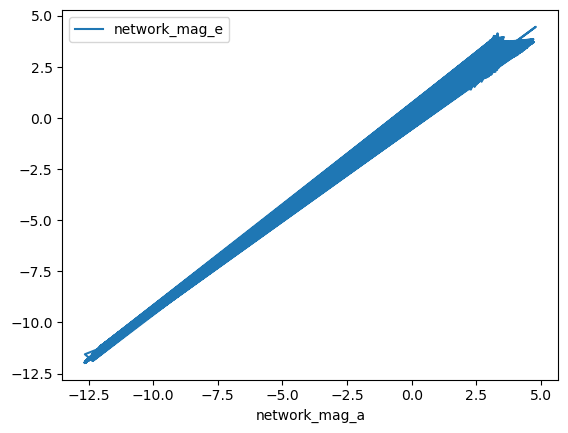

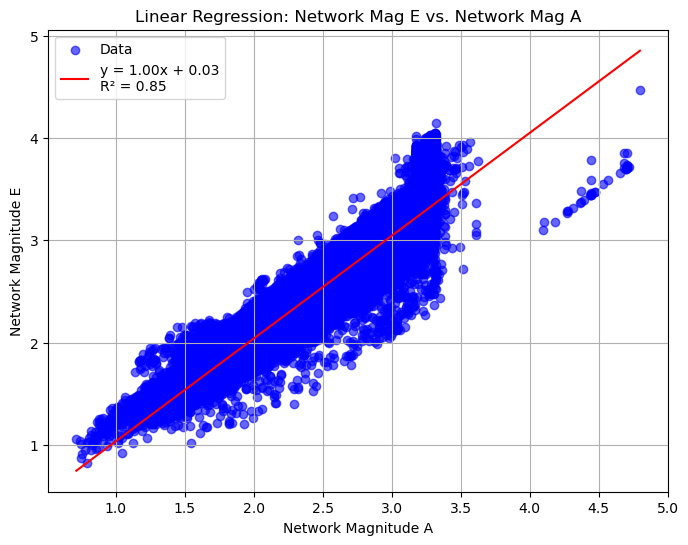

,Slope,Intercept,R-squared,p-value,Std Error
0,1.004665,0.031255,0.845686,0.0,0.003006


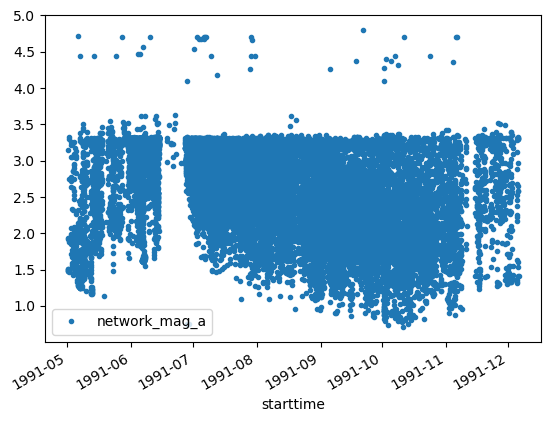

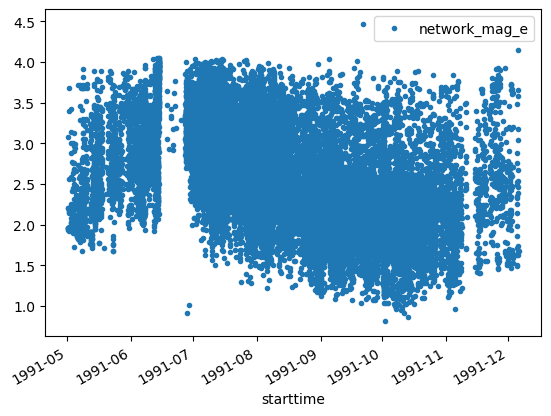

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
try:
    df_grouped['starttime'] = pd.to_datetime([x.datetime for x in df_grouped['starttime']])
except:
    pass
df_grouped['sta_mag_e'] = (np.log10(df_grouped['energy'])/2) - 1.0
df_grouped['sta_mag_a'] = np.log10(df_grouped['amplitude'])
display(df_grouped)

#df_grouped['starttime'] = pd.to_datetime(df_grouped['starttime'])

# Compute network magnitudes as the nanmedian of 'sta_mag_a' and 'sta_mag_e' per event (grouped by 'starttime')
df_network_mag = df_grouped.groupby('starttime', as_index=False).agg({
    'sta_mag_a': lambda x: np.nanmedian(x),
    'sta_mag_e': lambda x: np.nanmedian(x)
})

# Rename columns for clarity
df_network_mag.rename(columns={'sta_mag_a': 'network_mag_a', 'sta_mag_e': 'network_mag_e'}, inplace=True)

display(df_network_mag)

df_network_mag.plot(x='network_mag_a', y='network_mag_e')

# Drop rows with NaN values to ensure valid regression
df_network_mag_filtered = df_network_mag[df_network_mag['network_mag_a'] >= -2].reset_index(drop=True)
df_regression = df_network_mag_filtered.dropna(subset=['network_mag_a', 'network_mag_e'])

# Perform linear regression
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
    df_regression['network_mag_a'], df_regression['network_mag_e']
)

# Generate regression line
x_vals = np.linspace(df_regression['network_mag_a'].min(), df_regression['network_mag_a'].max(), 100)
y_vals = slope * x_vals + intercept

# Plot data and regression line
plt.figure(figsize=(8, 6))
plt.scatter(df_regression['network_mag_a'], df_regression['network_mag_e'], color='blue', alpha=0.6, label="Data")
plt.plot(x_vals, y_vals, color='red', label=f"y = {slope:.2f}x + {intercept:.2f}\nR² = {r_value**2:.2f}")

# Labels and title
plt.xlabel("Network Magnitude A")
plt.ylabel("Network Magnitude E")
plt.title("Linear Regression: Network Mag E vs. Network Mag A")
plt.legend()
plt.grid()

# Show plot
plt.show()

# Display regression results
regression_results = pd.DataFrame({
    "Slope": [slope],
    "Intercept": [intercept],
    "R-squared": [r_value**2],
    "p-value": [p_value],
    "Std Error": [std_err]
})

display(regression_results)

df_regression.plot(x='starttime', y='network_mag_a', style='.')
df_regression.plot(x='starttime', y='network_mag_e', style='.')
plt.show()

# wfdisc to Catalog
The objective now is to build a catalog using the wfdisc table as a starting point

Expand a wfdisc table to include an ObsPy ResourceIdentifier for each row (called 'waveform_id'), to identify the waveform data for that Trace, and also another ResourceIdentifier that identifies the event. But in that case, should I just be creating a Catalog, since that has ResourceIdentifier's built-in? I will sometimes want to create a wfdisc for continuous data that do not represent events, so should the event_id column be blank in that case?

1. Read hypo71 summary files into a Catalog object
2. Read monthly phase files into a Catalog object, associating picks with existing events, otherwise creating new events
3. Loop through wfdisc table. Associate each row with an existing pick. Add a reference to 

In [9]:
import os
from obspy import read_events
from libseisGT import parse_hypo71_file
hypo71qml = os.path.join(REPO_DIR, 'metadata', 'hypo71_catalog.xml')
if os.path.isfile(hypo71qml):
    hypo71_catalog = read_events(hypo71qml)

else:
    # read hypo71 file
    file_path = os.path.join(SOURCE_DIR,"Locations","Pinatubo_all.sum")  # Replace with actual file
    hypo71_catalog, unparsed_lines = parse_hypo71_file(file_path)

    # Print parsed events
    for event in hypo71_catalog:
        print(f"Time: {event.origins[0].time}, Lat: {event.origins[0].latitude}, Lon: {event.origins[0].longitude}, "
            f"Depth: {event.origins[0].depth}m, Mag: {event.magnitudes[0].mag}, "
            f"n_ass: {event.origins[0].comments[0]}, Time Residual: {event.origins[0].comments[1]}")

    hypo71_catalog.write(hypo71qml, format="QUAKEML")
    print(f"\n✅ Saved hypo71 catalog as {hypo71qml}")
print(f'The hypo71 catalog has {hypo71_catalog.count()} events')

The hypo71 catalog has 4632 events


# Parse monthly phase files

In [ ]:
import os
import glob
import re
from datetime import datetime, timedelta
from obspy import UTCDateTime
from obspy.core.event import Event, Origin, Arrival, Pick, WaveformStreamID, Catalog

def parse_monthly_phasefile(file_path, catalog, error_log="lines_that_could_not_be_parsed.txt", seconds=30):
    """
    Parses seismic phase data using **fixed character positions**.
    Creates an ObsPy Event object for each set of picks, separated by a line with just '10'.
    **Fixed-width character slicing ensures reliable parsing**
    """
    current_event = []  # Temporary storage for arrivals in the current event
    print(catalog)
    
    with open(file_path, 'r', encoding='utf-8', errors='replace') as file, open(error_log, 'a', encoding='utf-8') as error_file:
        for line in file:

            line = line.rstrip()  # Strip \n and spaces

            # DEBUG: Print each line to confirm correct reading
            #print(f"DEBUG: Raw line -> '{line}'")

            # Print all positions where 'S' appears
            s_positions = [i for i, char in enumerate(line) if char == 'S']
            # Remove any positions outside the range [30, 40]
            s_positions = [pos for pos in s_positions if 35 <= pos <= 40]
            s_pos = 0
            if len(s_positions)==1:
                s_pos = s_positions[0]
            #print(f"DEBUG: 'S' found at positions -> {s_pos} in line: {repr(line)}")

            # If a "10" separator is found, start a new event
            if line.strip() == "10":
                if current_event:  # Save the previous event if it has arrivals
                    obspyevents = create_obspy_event(current_event, seconds=seconds)
                    catalog.events.extend(obspyevents) 
                    current_event = []  # Reset for the next event
                continue  # Skip processing the separator itself

            #  **Fixed Character Positions**
            station = line[0:3].strip()  # Positions 1-3
            if station.lower()=='xxx' or len(station)<3:
                continue
            orientation = line[3:4].strip()  # Position 4
            if orientation=='P':
                line = line[0:4] + '  ' + line[4:]
            p_arrival_code = line[4:8].replace(' ', '?')   # Positions 5-8
            if line[8]==' ':
                timestamp_str = line[9:24].strip().replace(" ", "0")  # Positions 10-24 (date/time)
            else:
                timestamp_str = line[8:23].strip().replace(" ", "0")  # Positions 10-24 (date/time)                
            s_wave_delay = line[s_pos-7:s_pos-1].strip() if s_pos else ""
            if s_pos>0:
                if len(line)>s_pos+3:
                    s_arrival_code = line[s_pos-1:s_pos+3].replace(' ', '?')
                else:
                    s_arrival_code = line[s_pos-1:].ljust(4).replace(' ', '?')
            else:
                s_arrival_code = ""  
            unknown_str = line[42:].strip() if len(line) > 47 else ""
            unknown_str = re.sub(r'[^\x20-\x7E]', '', unknown_str).strip()  # Keeps only printable ASCII characters

            #  **Check if P-wave data exists (only if 'P' in position 6, index 5)**
            has_p_wave = len(p_arrival_code) >= 2 and p_arrival_code[1] == "P"

            #  **Check if S-wave data exists (only if 'S' in position 2, index 1 of S-wave code)**
            has_s_wave = s_pos>0

            # Convert spaces and '?' in arrival codes to 'unknown'
            p_arrival_code = p_arrival_code.replace("?", " ") if has_p_wave else "unknown"
            s_arrival_code = s_arrival_code.replace("?", " ") if has_s_wave else "unknown"

            # Convert timestamp to UTC
            add_secs = 0
            if timestamp_str[-5:]=='60.00':
                timestamp_str = timestamp_str.replace('60.00', '00.00')
                add_secs += 60
            if timestamp_str[-7:-5]=='60':
                timestamp_str = timestamp_str.replace('60', '00')
                add_secs += 3600                
            try:
                timestamp = UTCDateTime(datetime.strptime(timestamp_str, "%y%m%d%H%M%S.%f"))
            except:
                try:
                    timestamp = UTCDateTime(datetime.strptime(timestamp_str, "%y%m%d%H%M"))
                except:
                    continue
            timestamp = timestamp + add_secs

            #  **Determine SEED channel**
            if orientation in "ZNE":  # Standard orientations
                channel = f"EH{orientation}"
            elif orientation == "L":  # Special case for "L"
                channel = "ELZ"
            else:
                channel = f'??{orientation}'
                #raise ValueError(f"Unknown orientation '{orientation}' in '{station}'")

            # Construct SEED ID
            seed_id = f"XB.{station}..{channel}"

            #  **Store P-wave arrival**
            if has_p_wave:
                p_arrival = {
                    "seed_id": seed_id,
                    "time": timestamp,
                    "onset": p_arrival_code[0] if p_arrival_code[0] in ["I", "E"] else "unknown",
                    "type": "P",
                    "first_motion": p_arrival_code[2] if p_arrival_code[2] in ["U", "D"] else "unknown",
                    "uncertainty": int(p_arrival_code[3]) if p_arrival_code[3].isdigit() else None,
                    "unknown": unknown_str
                }
                current_event.append(p_arrival)

            #  **Store S-wave arrival**
            if has_s_wave and s_wave_delay.replace(".", "").isdigit():
                s_wave_time = timestamp + timedelta(seconds=float(s_wave_delay))
                s_arrival = {
                    "seed_id": seed_id,
                    "time": s_wave_time,
                    "onset": s_arrival_code[0] if s_arrival_code[0] in ["I", "E"] else "unknown",
                    "type": "S",
                    "first_motion": s_arrival_code[2] if s_arrival_code[2] in ["U", "D"] else "unknown",
                    "uncertainty": int(s_arrival_code[3]) if s_arrival_code[3].isdigit() else None,
                    "unknown": unknown_str
                }
                current_event.append(s_arrival)

            '''
            except Exception as e:
                error_file.write(f"Error parsing line: {line}\nReason: {e}\n")
                error_file.write(f'{station}, {orientation}, {p_arrival_code}, {timestamp_str}, {s_wave_delay}, {s_arrival_code}, {optional_number}'+'\n\n')
                continue  # Skip this line and move to the next
            '''

    # Save the last event if there are remaining arrivals
    if current_event:
        obspyevents = create_obspy_event(current_event, seconds=seconds)
        catalog.events.extend(obspyevents)

def create_obspy_event(current_event, seconds=30):
    """
    Saves an event (list of arrivals) to an ObsPy Event object.
    
    Returns:
        obspy.core.event.Event: The ObsPy Event object.
    """

    picks = []  # List to store Pick objects

    events = []

    for arrival in current_event:

        seed_id = arrival['seed_id']
        pick_time = UTCDateTime(arrival['time'])
        onset = arrival['onset'] if arrival['onset'] != "unknown" else None
        if onset=='E':
            onset = 'emergent'
        elif onset=='I':
            onset='impulsive'
        else:
            onset=='questionable'
        phase_hint = arrival['type']  # "P" or "S"
        polarity = arrival['first_motion'] if arrival['first_motion'] != "unknown" else None
        if polarity=='U':
            polarity='positive'
        elif polarity=='D':
            polarity='negative'
        else:
            polarity='undecidable'
        uncertainty = float(arrival['uncertainty']) if arrival['uncertainty'] else None

        # Create a Pick object
        pick = Pick(
            time=pick_time,
            waveform_id=WaveformStreamID(seed_string=seed_id),
            onset=onset,
            phase_hint=phase_hint,
            polarity=polarity
        )
        picks.append(pick)
    
    # check that picks are within (say) 30-seconds of each other. arrange into groups
    grouped_picks = group_picks(picks, seconds=seconds)
    ptimes = sorted([p.time for p in picks])
    ptimerange = ptimes[-1] - ptimes[0]
    print(f'got {len(grouped_picks)} groups of picks from pick times that spread {ptimerange} seconds')
    if ptimerange > seconds and len(grouped_picks) < 2:
        raise ValueError('failed!')

    if len(grouped_picks)>1:
        for i, group in enumerate(grouped_picks):
            print(f'group: {i}')
            for p in group:
                w = p.waveform_id
                seed_id = '.'.join((w.network_code, w.station_code, w.location_code, w.channel_code))
                print(p.time, seed_id, p.phase_hint, )
            print()
    for group in grouped_picks:
        event = Event()  # Create an empty ObsPy Event
        arrivals = []

        for pick in group:

            # Create an Arrival object (linking to the Pick)
            arrival = Arrival(
                pick_id=pick.resource_id,
                phase=phase_hint,
                time_residual=uncertainty if uncertainty is not None else 0.0
            )
            arrivals.append(arrival)
    
        # Create an Origin object (hypocenter)
        origin_time = min(pick.time for pick in picks)  # Use earliest pick as origin time
        origin = Origin(
            time=origin_time,
            arrivals=arrivals
        )

        # Add Origin and Picks to Event
        event.origins.append(origin)
        event.picks.extend(picks)

        # append event to list of events (which gets added to full catalog)
        events.append(event)

        ptimes = sorted([p.time for p in event.picks])
        ptimerange = ptimes[-1] - ptimes[0]
        if ptimerange > 90:
            raise ValueError(f'Got an event with {ptimerange} seconds of data')        

    return events

def group_picks(picks, seconds=30):
    """
    Groups ObsPy Pick objects into clusters where each pick's time is within 'threshold' seconds of another in the group.

    :param picks: List of ObsPy Pick objects
    :param threshold: Maximum allowed time difference in seconds
    :return: List of lists, where each sublist contains grouped Pick objects
    """
    if not picks:
        return []
    
    # Sort picks by time
    picks = sorted(picks, key=lambda p: p.time)
    
    groups = []
    current_group = [picks[0]]

    for i in range(1, len(picks)):
        #if (picks[i].time - current_group[-1].time) <= seconds:
        if (picks[i].time - current_group[0].time) <= seconds:    
            current_group.append(picks[i])
        else:
            groups.append(current_group)
            current_group = [picks[i]]
    
    # Append last group
    groups.append(current_group)

    return groups

#  **Process all `pin*91.pha` files**
SOURCE_DIR = '/data/Pinatubo/PHASE'
REPO_DIR = '/home/thompsong/Developer/Pinatubo1991SeismicData'
REA_DIR = '/data/SEISAN_DB/REA/PINAT'
WAV_DIR = '/data/SEISAN_DB/WAV/PINAT'
phasesqml = os.path.join(REPO_DIR, 'metadata', 'phases_catalog.xml')

if os.path.isfile(phasesqml):
    phases_catalog = read_events(phasesqml)
else:
    input_files = sorted(glob.glob(os.path.join(SOURCE_DIR,"pin*91.pha")))

    # Create an empty ObsPy Catalog
    catalog = Catalog()

    for file in input_files:
        print(f"Processing: {file}")
        parse_monthly_phasefile(file, catalog, seconds=10)

    import pickle
    with open("temp_catalog.pkl", "wb") as f:
        pickle.dump(catalog, f)

    # Sort the events by the first origin time
    phases_catalog = sorted(catalog, key=lambda event: event.origins[0].time if event.origins else None)

    # Convert back to an ObsPy Catalog
    phases_catalog = catalog.__class__(phases_catalog)

    # write to QML
    phases_catalog.write(phasesqml, format="QUAKEML")
    print(f"\n✅ Saved phases catalog as {phasesqml}")

print(f'The phases catalog has {phases_catalog.count()} events')

Processing: /data/Pinatubo/PHASE/pinaug91.pha
0 Event(s) in Catalog:

got 1 groups of picks from pick times that spread 4.7 seconds
got 2 groups of picks from pick times that spread 25.8 seconds
group: 0
1991-07-31T16:07:18.650000Z XB.FNG..EHZ P
1991-07-31T16:07:18.810000Z XB.QAD..EHZ P
1991-07-31T16:07:18.880000Z XB.BUG..EHZ P
1991-07-31T16:07:20.610000Z XB.CAB..EHZ P
1991-07-31T16:07:20.660000Z XB.CAB..EHN P
1991-07-31T16:07:20.670000Z XB.PI2..EHZ P
1991-07-31T16:07:21.730000Z XB.CRW..EHZ P

group: 1
1991-07-31T16:07:44.450000Z XB.CAB..EHN S

got 1 groups of picks from pick times that spread 1.85 seconds
got 2 groups of picks from pick times that spread 40.0 seconds
group: 0
1991-07-31T16:28:34.620000Z XB.FNG..EHZ P
1991-07-31T16:28:34.990000Z XB.QAD..EHZ P
1991-07-31T16:28:35.390000Z XB.BUG..EHZ P
1991-07-31T16:28:35.470000Z XB.PI2..EHZ P
1991-07-31T16:28:35.810000Z XB.CAB..EHZ P
1991-07-31T16:28:35.900000Z XB.CAB..EHN P
1991-07-31T16:28:36.230000Z XB.CRW..EHZ P

group: 1
1991-07-31

ValueError: Got an event with 369.66 seconds of data

# Merge catalogs

In [ ]:
import os
from obspy import UTCDateTime, read_events
from obspy.core.event import Catalog

def merge_catalogs_hypo71_phases(hypo71_catalog, phases_catalog, seconds=30):
    """
    Merges two ObsPy Catalog objects: one from HYPO71 and one from pick-based origins.
    """
    mergedcatalog = Catalog(events=[])
    merged_events = []
    
    # merge the hypo71 catalog into the phases catalog

    # Create sorted list of pick-based origin times
    sorted_pick_time_list = sorted(
            [(event.origins[0].time, event) for event in phases_catalog if event.origins], 
            key=lambda x: x[0]
        )
    print(f'the sorted phases catalog has {len(sorted_pick_time_list)} origin time, event tuples in it')
    
    matched_phases_events = []
    unmatched_hypo71_events = []

    print(f'Looping over the hypo71 catalog, which has {hypo71_catalog.count()} events')
    for hypo_event in hypo71_catalog:
        hypo_time = hypo_event.origins[0].time
        #print(hypo_time)
        
        # Find the first picktime event that has an origin time larger than the hypo71 event
        matching_event = next((event for pick_time, event in sorted_pick_time_list if pick_time > hypo_time and pick_time < hypo_time + seconds), None)
        matching_time = matching_event.origins[0].time
        print(f'best match for {hypo_time} in hypo71 catalog is {matching_time}: time difference is {matching_time - hypo_time}')

        if matching_event:
            merged_event = hypo_event.copy()
            merged_event.picks.extend(matching_event.picks)
            merged_events.append(merged_event)
            matched_phases_events.append(matching_event)
        else:
            unmatched_hypo71_events.append(hypo_event)

    unmatched_phases_events = phases_catalog.events        
    for phases_event in phases_catalog.events:
        if phases_event in matched_phases_events:
            unmatched_phases_events.remove(phases_event)

    print(f'we merged {len(merged_events)} events, and still have {len(unmatched_hypo71_events)} unmatched hypo71 events, and {len(unmatched_phases_events)} unmatched phases events')
    merged_events.extend(unmatched_hypo71_events)
    merged_events.extend(unmatched_phases_events)

    merged_events = sorted(merged_events, key=lambda event: event.origins[0].time if event.origins else None)
    mergedcatalog = Catalog(events=merged_events) 

    return mergedcatalog


mergedqml1 = os.path.join(REPO_DIR, 'metadata', 'Pinatubo_merged_hypo71_phases.xml')
if os.path.isfile(mergedqml1):
    mergedcatalog1 = read_events(mergedqml1)
else:
    mergedcatalog1 = merge_catalogs_hypo71_phases(hypo71_catalog, phases_catalog, seconds=30)
    mergedcatalog1.write(mergedqml1, format="QUAKEML")
print(f'The merged phases and hypo71 catalog has {mergedcatalog1.count()} events')


The merged phases and hypo71 catalog has 10651 events


In [ ]:
import numpy as np

def get_event_by_resource_id(catalog, resource_id):
    """
    Selects an Event object from a Catalog based on the Event.resource_id.

    Parameters:
        catalog (obspy.core.event.Catalog): The ObsPy Catalog object.
        resource_id (str): The resource_id of the Event to find.

    Returns:
        obspy.core.event.Event or None: The matching Event object, or None if not found.
    """
    for event in catalog:
        if str(event.resource_id) == resource_id:
            return event
    return None

def merge_events(event1, event2):
    """
    Merges two ObsPy Event objects into a single Event.

    Parameters:
        event1 (obspy.core.event.Event): First event.
        event2 (obspy.core.event.Event): Second event.

    Returns:
        obspy.core.event.Event: The merged event.
    """
    merged_event = Event()

    # Preserve the primary resource_id from event1
    merged_event.resource_id = event1.resource_id

    # Merge origins (avoid duplicates)
    merged_event.origins = list({orig.resource_id.id: orig for orig in event1.origins + event2.origins}.values())

    # Merge magnitudes (avoid duplicates)
    merged_event.magnitudes = list({mag.resource_id.id: mag for mag in event1.magnitudes + event2.magnitudes}.values())

    # Merge focal mechanisms (if available)
    merged_event.focal_mechanisms = list({fm.resource_id.id: fm for fm in event1.focal_mechanisms + event2.focal_mechanisms}.values())

    # Merge picks (avoid duplicates)
    merged_event.picks = list({pick.resource_id.id: pick for pick in event1.picks + event2.picks}.values())

    # Merge comments (combine lists)
    merged_event.comments = event1.comments + event2.comments

    return merged_event

def merge_wfdisc_with_picked_catalog(picked_catalog, df, wfdisc_catalog, seconds=20):
    """
    Associates MiniSEED files from a Seisan WAV database with Pick objects in an ObsPy Catalog.
    If a Pick's time falls within a MiniSEED file's time range, a Comment is added to the Event.

    Parameters:
        catalog (obspy.core.event.Catalog): The ObsPy Catalog containing Events with Picks.
        wav_directory (str): Path to the Seisan WAV database (e.g., "WAV/").

    Returns:
        obspy.core.event.Catalog: The updated Catalog with associated MiniSEED file paths in Comments.
    """

    merged_events = []
    matched_wfdisc_events = []
    bad_events = []
    '''
    # Convert DataFrame columns to NumPy arrays once (outside the loop)
    #starttimes = df["starttime"].to_numpy()
    #endtimes = df["endtime"].to_numpy()
    #event_ids = df["event_id"].to_numpy()  # Store event IDs as an array
    starttimes = df["starttime"].tolist()
    endtimes = df["endtime"].tolist()
    event_ids = df["event_id"].tolist()
    # Iterate through Events & Picks to check time association
    for event in picked_catalog:
        print(event.origins[0].time)
        associated_ids = set()  # Track unique MiniSEED files per event
        matching_event = None

        t0 = UTCDateTime()
    '''
    '''
    # Convert DataFrame columns to lists once (outside the loop)
    starttimes = df["starttime"].tolist()
    endtimes = df["endtime"].tolist()
    event_ids = df["event_id"].tolist()

    # Iterate through Events & Picks to check time association
    for event in picked_catalog:
        otime = event.origins[0].time
        associated_ids = set()  # Track unique MiniSEED files per event
        matching_event = None

        t0 = UTCDateTime()
        
        # Extract all pick times for the event and sort them
        pick_times = sorted([pick.time for pick in event.picks])
        
        if not pick_times:
            continue  # Skip event if no picks
        
        # Get the earliest and latest pick times
        earliest_pick = pick_times[0]
        latest_pick = pick_times[-1]
        print(f'otime: {otime}: earliest: {earliest_pick-otime}, latest: {latest_pick-otime}, latest-earliest = {latest_pick-earliest_pick}')

        # Instead of checking for each pick, check once per event
        matching_ids = [event_ids[i] for i in range(len(starttimes)) 
                        if starttimes[i] <= latest_pick and endtimes[i] >= earliest_pick]

        # Add matching file paths to the set
        if matching_ids:
            associated_ids.update(matching_ids)

        for pick in event.picks:
            t01 = UTCDateTime()
            pick_time = pick.time  # Extract pick time
            t02 = UTCDateTime()
            # Use NumPy to find matching indices instead of DataFrame filtering
            #matching_indices = np.where((starttimes <= pick_time) & (endtimes >= pick_time))[0]
            # List comprehension instead of DataFrame filtering
            matching_ids = [event_ids[i] for i in range(len(starttimes)) if starttimes[i] <= pick_time <= endtimes[i]]
                    
            t03 = UTCDateTime()
            # Retrieve matching event IDs
            #matching_ids = event_ids[matching_indices].tolist()
            t04 = UTCDateTime()
            # Add matching file paths to the set
            if matching_ids:
                associated_ids.update(matching_ids)
            t05 = UTCDateTime()
            #print(f'{t01-t0}, {t02-t01}, {t03-t02}, {t04-t03}, {t05-t04}')
        '''    
    # Convert DataFrame columns to lists once (outside the loop)
    df = df.sort_values(by='starttime')
    starttimes = df["starttime"].tolist()
    endtimes = df["endtime"].tolist()
    event_ids = df["event_id"].tolist()

    # Initialize an index to track how much of the sorted df we’ve processed
    start_index = 0  
    t0 = UTCDateTime()

    # Iterate through Events & Picks to check time association
    for event in picked_catalog:
        otime = event.origins[0].time
        if otime.year!=1991:
            continue
        associated_ids = set()  # Track unique MiniSEED files per event
        matching_event = None
        
        # Extract all pick times for the event - pick times are not presorted
        pick_times = [pick.time for pick in event.picks]    
        if len(pick_times)>0:
            earliest_pick = min(pick_times)
            latest_pick = max(pick_times)
            print(f'otime: {otime}: earliest: {earliest_pick-otime}, latest: {latest_pick-otime}, latest-earliest = {latest_pick-earliest_pick}')
            if latest_pick - earliest_pick > seconds:
                bad_events.append(event)
                continue
          
            # **Early stop optimization**: Remove outdated entries from lists
            while start_index < len(starttimes) and endtimes[start_index] < earliest_pick:
                start_index += 1  # Move forward past old entries

            # Now only check the reduced search space
            matching_ids = [event_ids[i] for i in range(start_index, len(starttimes))
                            if starttimes[i] <= earliest_pick and endtimes[i] >= latest_pick]

            # Add matching file paths to the set
            if matching_ids:
                associated_ids.update(matching_ids)

        # Match origin time instead - this can happen for events with no picks - just a hypocenter 
        # - or if the pick times did not fall inside the start and end times of a WAV file
        if len(associated_ids)==0:
            # an origin time could be before the corresponding WAV file starts, depending on the pretrigger window length used
            matching_rows = df[(df["starttime"] <= otime + seconds) & (df["endtime"] >= otime)]

            # Add matching file paths to the set
            matching_ids = matching_rows["event_id"].tolist()
            if matching_ids:
                associated_ids.update(matching_ids)                           

        if associated_ids:
            resource_ids = sorted(list(associated_ids))
            if isinstance(resource_ids[0], str):
                sorted_ids = sorted(resource_ids)
            else:
                sorted_ids = sorted(resource_ids, key=lambda rid: rid.id)
            resource_id_to_find = sorted_ids[-1] # we want the last file in the list, I think
            # this event from the picked catalog and from wfdisc_catalog should be merged
            matching_event = get_event_by_resource_id(wfdisc_catalog, resource_id_to_find)      
            
        if matching_event:
            merged_event = merge_events(matching_event, event)
            merged_events.append(merged_event) # add the merged event to the merged catalog
            matched_wfdisc_events.append(matching_event) # track the wfdisc_catalog events that have already been merged
        else:
            merged_events.append(event) # if no matching_event, we still want to pick this picked_catalog event into the merged catalog
        t1 = UTCDateTime()
        L = len(merged_events)
        print(f'Merged catalog has {L} events, elapsed time: {t1-t0} seconds, {(t1-t0)/L} seconds per event', '\n')

    print('Adding unmatched events from wfdisc_catalog')
    for wfdisc_event in wfdisc_catalog.events:
        if not wfdisc_event in matched_wfdisc_events:
            merged_events.append(wfdisc_event)   

    try:
        merged_events = sorted(merged_events, key=lambda event: event.origins[0].time if event.origins else None)        
    except:
        print('Could not sort events')
    merged_catalog = Catalog(events=merged_events)  
    bad_catalog = Catalog(events=bad_events)    

    return merged_catalog, bad_catalog
         
mergedqml2 = os.path.join(REPO_DIR, 'metadata', 'Pinatubo_merged_wfdisc_hypo71_phases.xml')
badqml = os.path.join(REPO_DIR, 'metadata', 'events_with_bad_picks.xml')
if os.path.isfile(mergedqml2):
    mergedcatalog2 = read_events(mergedqml2)
    bad_catalog = read_events(badqml)
else:
    mergedcatalog2, bad_catalog = merge_wfdisc_with_picked_catalog(mergedcatalog1, wfdiscdf, wfdisc_catalog)
    mergedcatalog2.write(mergedqml2, format="QUAKEML") 
    bad_catalog.write(badqml, format='QUAKEML')
print(f'The merged wfdisc, phases and hypo71 catalog has {mergedcatalog2.count()} events')

The merged wfdisc, phases and hypo71 catalog has 26206 events


In [27]:
if not 'bad_catalog' in locals():
    bad_catalog = read_events(badqml)
events = []
last_ptimes = []
last_otimes = []
for i, bad_event in enumerate(bad_catalog):
    otimes = [o.time for o in bad_event.origins]
    otime = min(otimes)
    ptimes = [p.time - otime for p in bad_event.picks]
    if len(ptimes)>0:
        print(f'event {i}: origins={len(otimes)}, otime={otime}, pick times {min(ptimes)} to {max(ptimes)}')
    else:
        print(f'event {i}: origins={len(otimes)}, otime={otime}, no picks')
    if (otimes == last_otimes and ptimes == last_ptimes):
        events.append(bad_event)
    last_otimes = otimes
    last_ptimes = ptimes
print(len(events))

event 0: origins=1, otime=1991-05-08T01:42:47.410000Z, pick times 0.0 to 49.89
event 1: origins=1, otime=1991-05-08T01:42:47.410000Z, pick times 0.0 to 49.89
event 2: origins=1, otime=1991-05-08T01:53:37.020000Z, pick times 0.0 to 41.9
event 3: origins=1, otime=1991-05-08T01:53:37.020000Z, pick times 0.0 to 41.9
event 4: origins=1, otime=1991-05-09T02:48:29.070000Z, pick times 0.0 to 32.68
event 5: origins=1, otime=1991-05-12T06:48:26.920000Z, pick times 0.0 to 28.96
event 6: origins=1, otime=1991-05-12T08:03:47.880000Z, pick times 0.0 to 51.39
event 7: origins=1, otime=1991-05-12T08:03:47.880000Z, pick times 0.0 to 51.39
event 8: origins=1, otime=1991-05-12T09:04:26.480000Z, pick times 0.0 to 28.27
event 9: origins=1, otime=1991-05-13T19:46:49.850000Z, pick times 0.0 to 50.94
event 10: origins=1, otime=1991-05-13T19:46:49.850000Z, pick times 0.0 to 50.94
event 11: origins=1, otime=1991-05-13T21:30:45.290000Z, pick times 0.0 to 46.09
event 12: origins=1, otime=1991-05-13T21:30:45.29000

We have a problem with 3748 events that have a pick time spread of more than 20 seconds. I didn't think this was possible, so we will have to go backwards and check where this is arising from.

# Write Catalog to REA

In [ ]:
import shutil
from obspy.io.nordic.core import blanksfile, _write_nordic
def catalog2rea(catalog, author='gt__', nordic_format='OLD', default_evtype='L'):
    """
    Write a Catalog object to a Seisan REA database
    Assumptions:
    1. catalog has been created using index_waveformfiles and thus has comments with the wavfile path, and what the corresponding sfile name should be
    2. if we merged catalogs, the first origin will be 
    """

    for event in catalog:

        otime = event.origins[-1].time
        evtype = event.event_type
        if not evtype:
            evtype = default_evtype
        ymdir = os.path.join(REA_DIR, otime.strftime('%Y'), otime.strftime('%m'))
        os.makedirs(ymdir, exist_ok=True)

        wavfiles = []
        sfiles = []
        for comment in event.comments:
            if 'wavfile:' in comment.text:
                wavfiles.append(os.path.basename(comment.text.split('wavfile:')[1]))
            if 'sfile:' in comment.text:
                sfiles.append(comment.text.split('sfile:')[1])

        if len(sfiles)>0:
            _write_nordic(event, sfiles[-1], userid=author, evtype=evtype, outdir=ymdir, wavefiles=wavfiles, 
                      explosion=False, nordic_format=nordic_format, overwrite=True, high_accuracy=False)  
        else:
            sfilename = blanksfile('', evtype, author, evtime=otime, nordic_format=nordic_format)
            sfile_path = os.path.join(ymdir, sfilename) 
            shutil.move(sfilename, sfile_path)

catalog2rea(mergedcatalog2)

# Make maps

In [ ]:
# Define the summit coordinates of Mount Pinatubo
pinatubo_lon, pinatubo_lat = 120.35, 15.13
print(pinatubo_lat, pinatubo_lon)

# Try to read STATION0.HYP
from importlib import reload
import seisan_classes
reload(seisan_classes)
hypfile = os.path.join(SOURCE_DIR, 'station0.hyp')
stationdf = seisan_classes.parse_STATION0HYP(hypfile)


from obspy import Trace
from libseisGT import fix_trace_id
stationdf['seed_id'] = None
netcode = 'XB'
for i,row in stationdf.iterrows():
    tr = Trace()
    #tr.id = f"{netcode}.{row['name'][0:3]}..EH{row['name'][3]}"
    tr.id = f".{row['name']}.."
    tr.stats.sampling_rate=100.0
    fix_trace_id(tr, legacy=True, netcode=netcode)
    stationdf.at[i, 'seed_id'] = tr.id

print(stationdf)

In [ ]:
# Visualization
import pygmt

# Extract unique stations (only first 3 characters of 'name')
#df_unique_stations = stationdf.groupby(stationdf['name'].str[:3]).first().reset_index()
df_unique_stations = stationdf.groupby(stationdf['name'].str[:3], as_index=False).first()

# Define map region and projection
region = [df_unique_stations['lon'].min() - 0.1, df_unique_stations['lon'].max() + 0.1,
          df_unique_stations['lat'].min() - 0.1, df_unique_stations['lat'].max() + 0.1]
resolution = '03s'
projection = 'M4i'
contour_interval=200
ergrid = pygmt.datasets.load_earth_relief(resolution=resolution, region=region)
fig = pygmt.Figure()

pygmt.makecpt(
    cmap='topo',
    series='-1300/1800/%d' % contour_interval,
    continuous=True
    )

fig.grdimage(
    grid=ergrid,
    region=region,
    projection=projection,
    shading=True,
    frame=True
    )

fig.basemap(map_scale="g120.5/14.97+w10k+f")

# plot continents, shorelines, rivers, and borders
fig.coast(
    region=region,
    projection=projection,
    shorelines=True,
    frame=True
    )
    
# plot the topographic contour lines
fig.grdcontour(
    grid=ergrid,
    interval=contour_interval,
    annotation="%d+f6p" % contour_interval,
    limit="-1300/1800", #to only display it below 
    pen="a0.15p"
    )
    
fig.colorbar(
    frame='+lTopography (m)',
    )

# Add station names as labels
fig.plot(x=df_unique_stations['lon'], y=df_unique_stations['lat'], style="s0.3c", fill="black", pen="black")
for _, row in df_unique_stations.iterrows():
    fig.text(x=row['lon'], y=row['lat'] + 0.02, text=row['name'][:3], font="12p,Helvetica-Bold,black", justify="CM", fill="white@50")

fig.plot(x=pinatubo_lon, y=pinatubo_lat, style="t0.6c", fill="red", pen="red")

# Show the figure
fig.show()

In [ ]:
# Visualization
import pygmt

# Extract unique stations (only first 3 characters of 'name')
#df_unique_stations = stationdf.groupby(stationdf['name'].str[:3]).first().reset_index()
df_unique_stations = stationdf.groupby(stationdf['name'].str[:3], as_index=False).first()

# Define map region and projection
pad = 5.0
region = [df_unique_stations['lon'].min() - pad, df_unique_stations['lon'].max() + pad,
          df_unique_stations['lat'].min() - pad, df_unique_stations['lat'].max() + pad]
resolution = '01m'
projection = 'M4i'
contour_interval=500
ergrid = pygmt.datasets.load_earth_relief(resolution=resolution, region=region)
fig = pygmt.Figure()
pygmt.makecpt(
    cmap='geo',
    series='-1/1800/%d' % contour_interval,
    continuous=True
    )

fig.grdimage(
    grid=ergrid,
    region=region,
    projection=projection,
    shading=True,
    frame=True,
    cmap="geo",
    )

fig.basemap(map_scale="g116.4/11.5+w200k+f")

# plot continents, shorelines, rivers, and borders
fig.coast(
    #water='white',
    region=region,
    projection=projection,
    shorelines=True,
    frame=True,
    )
'''
# plot the topographic contour lines
fig.grdcontour(
    grid=ergrid,
    interval=contour_interval,
    annotation="%d+f6p" % contour_interval,
    limit="-1300/1800", #to only display it below 
    pen="a0.15p"
    )
    '''



# Add a red arrow pointing to the Pinatubo summit
#fig.plot(x=[pinatubo_lon], y=[pinatubo_lat], style="v1c+b+h0.5", direction=[[-180], [1.5]], fill="red", pen="3p,red")

# Add a red label for "Pinatubo"
#fig.text(x=pinatubo_lon - 3, y=pinatubo_lat, text="Pinatubo", font="16p,Helvetica-Bold,red", justify="CM")    
fig.text(x=pinatubo_lon - 2, y=pinatubo_lat, text="Pinatubo", font="16p,Helvetica-Bold,red", justify="CM")  

fig.colorbar(
    frame='+lTopography (m)',
    )

fig.plot(x=pinatubo_lon, y=pinatubo_lat, style="t0.6c", fill="red", pen="red")
# Show the figure
fig.show()